<h1>Day-3</h1>
<h2>Path integral approximations to real time correlations</h2>
<h3>Mariana Rossi, Venkat Kapil, Eszter Sarolta Pos</h3>

In this exercise we will perform simulations of Ice Ih at 200 K, using a  simple empirical force field model based on TIP4P-like point charges. We will use this model to look at different path integral approximations to real time correlations, calculate imaginary time correlations from PI, and look at the relationship between them. The ice box contains 96 water molecules. All files necessary for the exercises below can be found in the `day-3` folder.

In [2]:
import argparse
import itertools
import sys
import os
import csv
import numpy as np
from ipi.utils.io import read_file_raw
from ipi.utils.units import unit_to_internal, unit_to_user
from ipi.utils.messages import verbosity
from matplotlib import pyplot as plt

<h2>Exercise 1 - Velocity and dipole real time correlation functions</h2>

In this first exercise, we will calculate time correlation functions with path integral based methods, namely centroid molecular dynamics (CMD) [1], ring polymer molecular dynamics (RPMD) [2], and thermostated ring polymer molecular dynamics (TRPMD)[3]. All these methods have been explained in the lectures, and we encourage you to look at the respective references for in more details. We note that for the TIP4P-style of charges, the dipole moment is a linear function of the coordinates, and therefore the dipole estimator in CMD, RPMD, and TRPMD is always the same and can be calculated from the centroid positions (or velocities, in the case of its derivative). Due to time constraints we will only perform short (10 ps) simulations, and you’ll be provided extensive outputs for further analysis in the exercises that require it. Inputs for simulating different PI-based methods are also provided.

<h3> Vibrational spectra with classical nuclei (Time: 10 minutes)</h3>

We will start by calculating both dipole and velocity correlation functions with classical nuclei. In order to do this, we have provided pre-computed i-PI checkpoint files from a long thermalization run of Ice Ih at 200 K. Checkpoint files are a feature of i-PI that can be written through the keyword ```<checkpoint>``` in the ```<output>``` block of i-PI’s input file, for which a syntax example would be: 

   ```<checkpoint filename="restart" stride="2000" overwrite="false"/>```

Inserting this keyword in a thermalization run provides a series of files that can be used to restart simulations from different points of the thermalization simulation (defined by the option stride). You can find checkpoint files from an NVT run with classical nuclei in the `ex-1/checkpoint-nvt` directory.
In order to run the NVE trajectory needed to compute the correlation functions, do:

`$ cd ex-1/nve` <br>
`$ vi nve.xml`

The file `nve.xml` is an example of input for NVE simulations. Take some time reading through it. For the current simulation, the most important quantity we will print out is the velocity of the atoms (here given by the centroid velocities since there is only one bead). You will notice that there are some fields marked with `xxx` in the input file. These should be substituted by a number of your choice, corresponding to the identity of the checkpoint file you want to choose. You can substitute `xxx` by a number by hand or use a command.
For example, in order to create a new directory with all necessary input files, run:

`$ number=6` <br>
`$ mkdir dir_${number}` <br>
`$ sed "s/xxx/${number}/g" nve.xml > dir_${number}/input.xml` <br>
`$ cd dir_${number}` <br>
`$ cp ../../lammps_inputs/* .`
    
Now the directory `dir_${number}` contains all input files necessary to start our simulation. 

In order to launch one instance of i-PI and LAMMPS, run:

`$ i-pi input.xml &> log.ipi &` <br>
`$ what=$(grep addr input.xml | sed "s/.*<address>//; s/<\/address>//")` <br>
`$ sed "s/addr/$what/" in.tip4pf | lmp_serial &> log.lammps &`

The two last lines are there so as to inform LAMMPS (by changing its input), the address of the UNIX socket that is currently used by the i-PI server.

After approximately 10 minutes this simulation should be done and you can analyze the outputs. Immediately after this simulation ends, launch the TRPMD simulation on the second item below before analyzing the outputs, so that it starts running in the background.

Look at outputs using gnuplot and vmd . In order to create the dipole and velocity autocorrelations, we provide scripts in the `day-3/tools` folder that uses trajworks functionalities in order to perform Fourier transforms and calculate autocorrelation functions, called `post-vel` and `post-dpl` . Note that we will actually calculate the dipole derivative autocorrelation function, which already includes an extra $\omega^2$ factor in comparison to the dipole autocorrelation.

Go to the folder where you performed the simulation and run the following
commands:

`$ cp ../../../tools/post* .` <br>
`$ cp ../../../tools/charges.tip4pf .` <br>
`$ sh post-dpl` <br>
`$ sh post-vel` <br>

Visualize the files `dpl.ft` (Fourier transform of the dipole autocorrelation) and `vel.ft` (Fourier transform of the velocity autocorrelation).
Analyze similarities and differences between them (remember this is a short simulation that cannot yield very converged correlation functions). In the folder `ex-1/precomputed-trajectories/nve/` you will find several longer precomputed and preanalyzed trajectories. Look for the `*.vv` and `*.dpl` files.

When we calculate the dipole autocorrelation function we need to first calculate the total dipole of each frame. Let us write a simple function for this.

To calculate the dipole of a water molecule in the TIP4PF potential, we swap the oxygen atom with a dummy atom, M, that carries a the charge and is placed at

$$ r_M = \gamma\ r_O + (1-\gamma)\ \frac{r_{H_a}+r_{H_b}}{2} $$

In [34]:
number = 6
# get the charges for the dipole calculation and store them in a dictionary
chargedict = {}
with open("/home/epos/tutorials-schools/tutorial-3/ex-1/nve/dir_%d/charges.tip4pf"%number) as f:
    for line in f:
        (key, val) = line.split()
        chargedict[key] = float(val)

In [37]:
# TIP4PF setup
gamma = 0.73612
weights = np.array([gamma, 0.5-0.5*gamma, 0.5-0.5*gamma])

# determining the position of the M dummy atom
def M_pos(matrix,weights):
    coordM = np.dot(matrix.T,weights)
    return coordM

In [38]:
# opening the .xyz file and reading in the first frame
ff = open("/home/epos/tutorials-schools/tutorial-3/ex-1/nve/dir_%d/h2o-ice-nve.vc.xyz"%number)
rr = read_file_raw("xyz", ff)            
ndof = len(rr['data'])                   # number of entries read in in a frame (96*3*3 = 864)
nspecies = int(ndof / 3)                 # number of atoms in the ice slab (96*3 = 288)
natomm = 3                               # number of atoms in the H2O molecule
ch = np.zeros((nspecies))


framexyz = rr['data'].reshape((int(ndof / 3), 3))
label = rr['names']
for z in range(nspecies):
    if(z%natomm==0):
        framexyz[z] = M_pos(framexyz[z:z+natomm,:],weights)
        label[z] = 'M'
    ch[z] = chargedict[label[z]]
dpl = np.dot(framexyz.T,ch)

print('# Calculating the dipole of the first frame of the ice slab\n#     dipole_x           dipole_y           dipole_z   ')
print('# %15.8e    %15.8e    %15.8e'%(dpl[0], dpl[1], dpl[2] ))

# Calculating the dipole of the first frame of the ice slab
#     dipole_x           dipole_y           dipole_z   
#  9.74735585e-03     2.88832996e-03    -5.09980561e-03


In [39]:
# Calculates the autocorrelation function using the   

for tt in range(mlag+1):
    for xx in range(3):
        autocorr[tt,xx] = np.dot(dplfull[:len(dplfull)-tt,xx].T,dplfull[tt:,xx])/(len(dplfull)-tt)
autocorr /= autocorr[0]

NameError: name 'mlag' is not defined

<h3>Vibrational spectra with quantum nuclei (Time: 1 hour)</h3>

Due to time constrains, we will only perform one TRPMD run with 48 beads. This simulation takes around one hour. For RPMD, more simulations would be needed for a reasonable spectra due to its poor ergodicity, and for (partially adiabatic) CMD, due to the much smaller time step required, the simulation would take 10 times longer. Templates of the input files for the corresponding simulations are provided in the folders `ex-1/rpmd/` and `ex-1/cmd/`. The input file for this simulation will be in the `ex-1/trpmd` folder. The checkpoints from a PIMD simulation that we will use to start the TRPMD one can be found in `ex-1/checkpoint-pimd`. The set of bash commands you will need to launch this simulation are the following (you can change the variable number):

```$ cd ex-1/trpmd``` <br>
```$ number=6``` <br>
```$ mkdir dir_${number}``` <br>
```$ sed "s/xxx/${number}/g" trpmd.xml > dir_${number}/input.xml``` <br>
```$ cd dir_${number}/``` <br>
```$ cp ../../lammps_inputs/* .``` <br>
```$ i-pi input.xml &> log.ipi &``` <br>
```$ what=$(grep addr input.xml | sed "s/.*<address>//; s/<\/address>//")``` <br>
```$ for i in {1..8}; do sed "s/addr/$what/" in.tip4pf | lmp_serial &> log.$i & done``` 

Beyond the velocities, here we will print out also the positions and forces on each bead, which is necessary to build the imaginary time correlation functions that we will look at in <strong>Exercise 2</strong>.

Again after the simulation is done, from the simulation directory run:

```$ cp ../../../tools/post* .``` <br>
```$ cp ../../../tools/charges.tip4pf .``` <br>
```$ sh post-dpl``` <br>
```$ sh post-vel```

Visualize below the files `dpl.ft` and `vel.ft` and compare them with their classical counterparts that were calculated in the previous item. Which differences do you observe? (Do not forget to change number in the top of the cell to the number you are using in your command line to run the simulations.)

In [5]:
number = 6
os.chdir('ex-1/trpmd/')
try:
    os.chdir('dir_%d/'%number)
except:
    raise ValueError("The directory dir_%d cannot be found."%number)
dplFT = np.loadtxt('dpl.ft', usecols=(0,1))

plt.plot(dplFT[:,0],dplFT[:,1], label = '%s'%mm)
plt.xlim([0,4500])
plt.xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
plt.legend()
plt.show()

os.chdir('../../')

ValueError: The directory dir_4 cannot be found.

In [ ]:
number = 4
os.chdir('ex-1/trpmd/')

velFT = np.loadtxt('vel.ft', usecols=(0,1))

plt.plot(velFT[:,0], velFT[:,1], label = '%s'%mm)
plt.xlim([0,4500])
plt.xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
plt.legend()

plt.show()

os.chdir('../../')

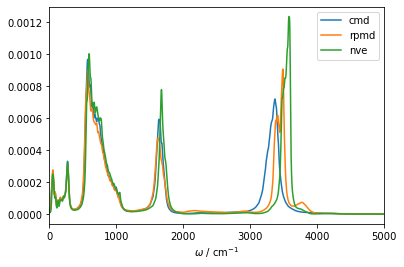

In [4]:
methods = ['cmd', 'rpmd', 'nve']
os.chdir('ex-1/precomputed-trajectories/')
for mm in methods:
    os.chdir(mm + '/' + mm +'_4/')
    velFT = np.loadtxt('vel.ft', usecols=(0,1))
    plt.plot(velFT[:,0],velFT[:,1], label = '%s'%mm)
    os.chdir('../../')
plt.xlim([0,5000])
plt.xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
plt.legend()
plt.plot()
os.chdir('../../')

You’ll find many precomputed and preprocessed trajectories from each different path integral based method in the directories 

```ex-1/precomputed-trajectories/rpmd/```  <br> 
```ex-1/precomputed-trajectories/trpmd/```  <br> 
```ex-1/precomputed-trajectories/cmd/``` <br>


Visualize and compare all Fourier transformed functions of dipole and velocities (`.dpl` and `.vv`), as computed from the different methods. Can you spot the spurious resonances in RPMD and the curvature problem in CMD? And do you see that the TRPMD peaks are much broader than the classical ones?

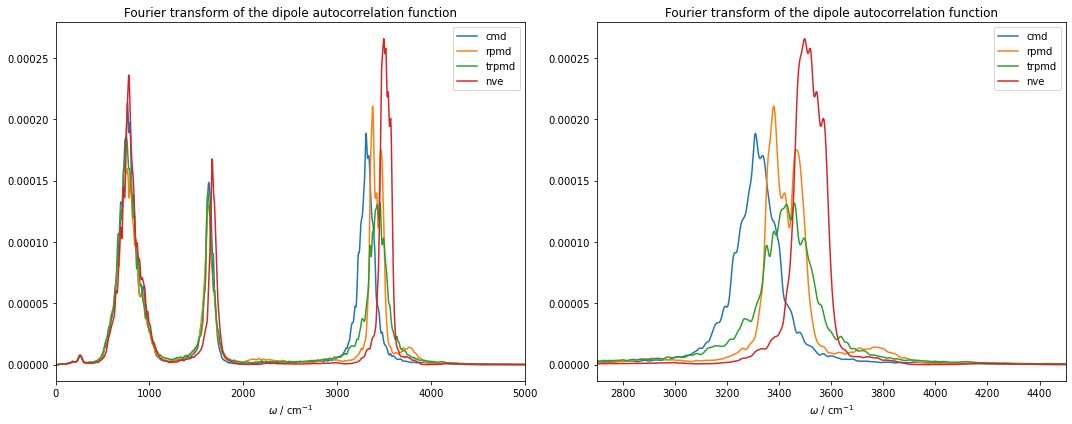

In [44]:
methods = ['cmd', 'rpmd', 'trpmd', 'nve']
os.chdir('ex-1/precomputed-trajectories/')

fig,(ax1,ax2) = plt.subplots(1,2, figsize=[15,6])
ax1.set_title(r'Fourier transform of the dipole autocorrelation function')
for mm in methods:
    os.chdir(mm + '/')
    dpl = np.loadtxt(mm + '.dpl', usecols=(0,1))
    ax1.plot(dplFT[:,0],dplFT[:,1], label = '%s'%mm)
    os.chdir('../')
ax1.legend()
ax1.set_xlim([0,5000])
ax1.set_xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')


ax2.set_title(r'Fourier transform of the dipole autocorrelation function')
for mm in methods:
    os.chdir(mm + '/')
    dpl = np.loadtxt(mm + '.dpl', usecols=(0,1))
    ax2.plot(dpl[:,0],dpl[:,1], label = '%s'%mm)
    os.chdir('../')
ax2.set_xlim([2700,4500])
ax2.set_xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
ax2.legend()

plt.tight_layout()
plt.show()
os.chdir('../../')

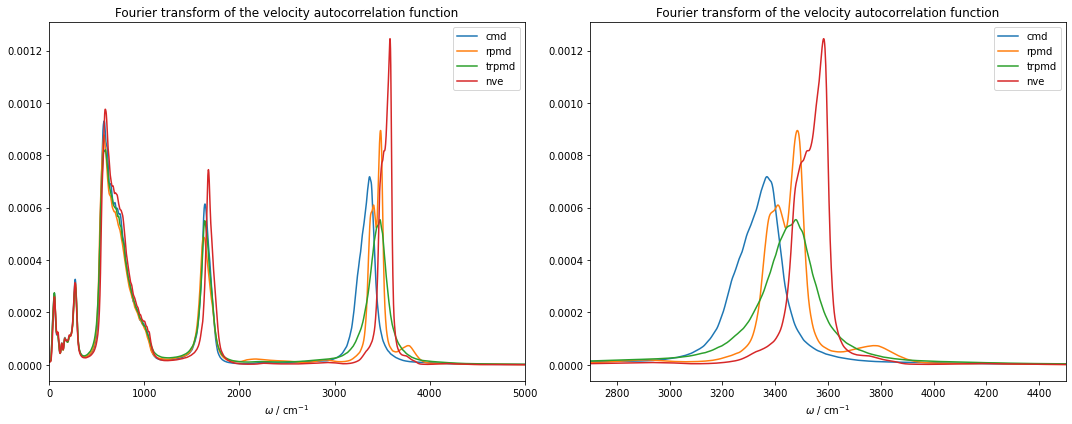

In [45]:
methods = ['cmd', 'rpmd', 'trpmd', 'nve']
os.chdir('ex-1/precomputed-trajectories/')

fig,(ax1,ax2) = plt.subplots(1,2, figsize=[15,6])
ax1.set_title(r'Fourier transform of the velocity autocorrelation function')
for mm in methods:
    os.chdir(mm + '/')
    vel = np.loadtxt(mm + '.vv', usecols=(0,1))
    ax1.plot(vel[:,0],vel[:,1], label = '%s'%mm)
    os.chdir('../')
ax1.legend()
ax1.set_xlim([0,5000])
ax1.set_xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')


ax2.set_title(r'Fourier transform of the velocity autocorrelation function')
for mm in methods:
    os.chdir(mm + '/')
    vel = np.loadtxt(mm + '.vv', usecols=(0,1))
    ax2.plot(vel[:,0],vel[:,1], label = '%s'%mm)
    os.chdir('../')
ax2.set_xlim([2700,4500])
ax2.set_xlabel(r'$\omega\ /\ \mathrm{cm}^{-1}$')
ax2.legend()

plt.tight_layout()
plt.show()
os.chdir('../../')

<h2>Exercise 2 - Velocity imaginary time correlation function </h2>

In this exercise, we will calculate an example of an imaginary time correlation function, namely the velocity-velocity imaginary time correlation. These quantities are exact within the PI formalism and can be computed from PIMD, CMD, RPMD, and TRPMD, always yielding the same result since all these methods preserve ensemble. 

A direct estimator for the imaginary time correlation function of the imaginary time $i \lambda_j$, with $\lambda_j=j\beta_P\hbar,\ j = 0, ..., n − 1$, and $\lambda_n = \lambda_0$ is

$$c_\mathrm{vv}(i\lambda t) = \sum_k^N\Big[ \dfrac{3}{\beta_P m_k} - \dfrac{\omega_P}{P} \sum_i^{P-1} \Big\langle (q_i^{(k)}-q_{i+1}^{(k)})(q_{i+j}^{(k)}-q_{i+j+1}^{(k)})\Big\rangle\Big] $$

For hints on the derivation of the equation above, check the appendix of Ref. [4]. This expression can be recast to a centroid virial estimator form that is

$$c_\mathrm{vv}(i\lambda t) = \sum_k^N\Big[ \dfrac{3}{\beta m_k} - \dfrac{1}{P m_k} \sum_i^{P-1} \Big\langle(q_{i+j}^{(k)}-\overline{q})\dfrac{dV(q_i^{(k)})}{dq_i^{(k)}}\Big\rangle\Big] $$

where $\overline{q}$ is the centroid position. This is what we will calculate from our simulation. A script to calculate this expression is available in `tools/posforce2imaginaryvv.py`. 
Run the following commands:

```$ cd ex-2``` <br>
```$ cp -r ../ex-1/trpmd/dir_* .``` <br>
```$ cd dir_*``` <br>
```$ python ../../tools/posforce2imaginaryvv.py h2o-ice-trpmd 200```

The file generated `h2o-ice-trpmd.imvacf` contains the velocity imaginary time correlation, where the x axis is imaginary time in units of $\lambda_j\hbar /(P β \hbar)$. Plot this quantity. For the temperature we are simulating, we know the imaginary time correlation function through an imaginary time slice from $0\ \mathrm{to}\ \beta\hbar = 38.2\ \mathrm{fs}$. A more converged imaginary time velocity correlation function is given in `ex-2/precomputed-imvacf/` .


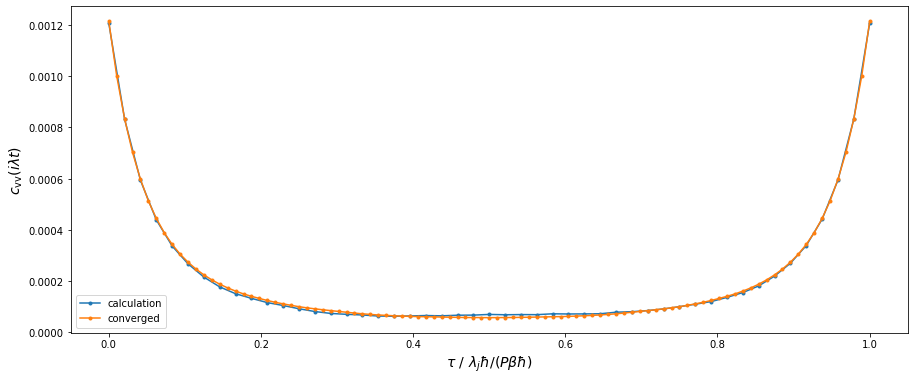

In [87]:
## PLOTTING ##
ax,fig = plt.subplots(figsize=(15,6))

imvacf = np.loadtxt('ex-2/dir_%d/h2o-ice-trpmd.imvacf'%number, usecols=(0,1))
conv_imvacf = np.loadtxt('ex-2/precomputed-imvacf/conv.imvacf', usecols=(0,1))
plt.plot(imvacf[:,0], imvacf[:,1], 'o-', ms=3, label=r'calculation')
plt.plot(conv_imvacf[:,0], conv_imvacf[:,1], 'o-', ms=3, label=r'converged')
plt.xlabel(r'$\tau\ /\ \lambda_j\hbar/(P\beta\hbar)$', fontsize=14)
plt.ylabel(r'$c_\mathrm{vv}(i\lambda t)$', fontsize=14)

plt.legend()
plt.show()

<h2>Exercise 3 - Relationship between imaginary and real time correlations</h2>

A way to check the quality of the real time autocorrelation function approximated by the PI-based methods (like the ones calculated in <strong> Exercise 1</strong>) is to look at sum rules that connect the real time with the imaginary time correlations. For the velocity real and imaginary time correlations, the relationship is 

$$c_\mathrm{vv}(i\lambda t) = \int_0^\infty f(\lambda,\omega) F_\mathrm{vv}(\omega) d\omega $$

$$f(\lambda,\omega) = \dfrac{\beta\hbar\omega \cosh({\beta\hbar\omega/2}-\lambda\hbar\omega)}{2\pi\sinh({\beta\hbar\omega/2})}$$

where $F_\mathrm{vv}(\omega)$ is the Fourier transform of the Kubo transformed real time velocity correlation function.

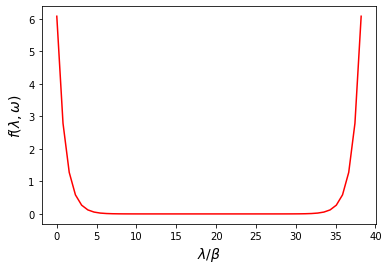

In [84]:
### Plotting the conversion factor, f(lambda,omega)
omega = 1
betahbar = 38.2

def conversionFactor(lmbdahbar, omega):
    return betahbar*omega*np.cosh((betahbar/2.-lmbdahbar)*omega)/2./np.pi/np.sinh(betahbar/2.)

lmbda = np.linspace(0,betahbar)
plt.plot(lmbda, conversionFactor(lmbda, omega), 'r-', label=r'$f(\lambda, \omega)$')
#plt.legend(loc='upper right')
plt.xlabel(r'$\lambda/\beta$', fontsize=14)
plt.ylabel(r'$f(\lambda, \omega)$', fontsize=14)
plt.show()

In Ref. [5] one can also find the expression that relates the  imaginary time square displacement and the real time velocity correlation function. Ref. [4] and references therein also point to derivations of these expressions. 

By reconstructing $c_\mathrm{vv}$ from the vibrational spectra obtained with either TRPMD, RPMD, or CMD, or even  from a simulation with classical nuclei (our NVE) and comparing to the exact $c_\mathrm{vv}(i\lambda\hbar)$ obtained in <strong>Exercise 2</strong>, one can assess (even if indirectly) how large the errors are. 
In order to reconstruct the imaginary time correlations from real time data we provide the script `tools/get_imacf_from_real.py`. The syntax is:

`python get_imacf_from_real.py [name] [temperature] [nslices]`

where `nslices` is the number of imaginary time slices (or ''beads'') one wants to reconstruct.

In the folder `ex-3/convergedspecs` you will find the files `nve.vv`, `trpmd.vv`, `rpmd.vv`, and `cmd.vv`. Type:

```$ cd ex-3/convergedspecs``` <br>
```$ python ../../tools/get_imacf_from_real.py nve.vv 200 64 > nve.imvacf``` <br>
```$ python ../../tools/get_imacf_from_real.py trpmd.vv 200 64 > trpmd.imvacf``` <br>
```$ python ../../tools/get_imacf_from_real.py rpmd.vv 200 64 > rpmd.imvacf``` <br>
```$ python ../../tools/get_imacf_from_real.py cmd.vv 200 64 > cmd.imvacf``` 

Compare all the imaginary time correlations with the one provided in `ex-2/precomputed-imvacf/`.
Are the imaginary functions reconstructed from different methods appreciably different? Can you think about reasons for their similarities/differences? (Hint: look at the expressions above.)

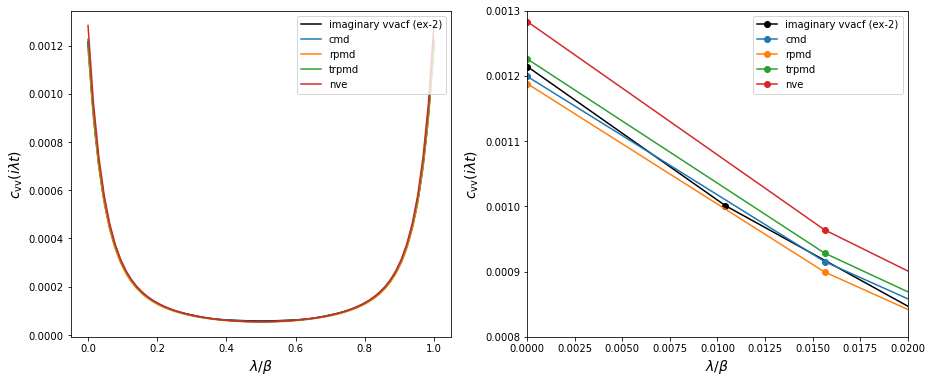

In [80]:
methods = ['cmd', 'rpmd', 'trpmd', 'nve']
imvacf = np.loadtxt('ex-2/precomputed-imvacf/conv.imvacf', usecols=(0,1))

fig,(ax1,ax2) = plt.subplots(1,2, figsize=[15,6])
ax1.plot(imvacf[:,0], imvacf[:,1], 'k-', label=r'imaginary vvacf (ex-2)')
for mm in methods:
    vv = np.loadtxt('ex-3/convergedspecs/%s.imvacf'%mm, usecols=(0,1))
    ax1.plot(vv[:,0], vv[:,1], '-', label=r'%s'%mm)
ax1.legend(loc='upper right')
ax1.set_xlabel(r'$\lambda/\beta$', fontsize=14)
ax1.set_ylabel(r'$c_\mathrm{vv}(i\lambda t)$', fontsize=14)


# panel zoomed in on the tau=0 behaviour
ax2.plot(imvacf[:,0], imvacf[:,1], 'ko-', label=r'imaginary vvacf (ex-2)')
for mm in methods:
    vv = np.loadtxt('ex-3/convergedspecs/%s.imvacf'%mm, usecols=(0,1))
    ax2.plot(vv[:,0], vv[:,1], '-o', label=r'%s'%mm)

ax2.legend()
ax2.set_xlim([0.,0.02])
ax2.set_ylim([0.0008,0.0013])
ax2.set_xlabel(r'$\lambda/\beta$', fontsize=14)
ax2.set_ylabel(r'$c_\mathrm{vv}(i\lambda t)$', fontsize=14)
plt.show() 

<h2>References</h2>
[1] Jianshu Cao and Gregory A Voth. The formulation of quantum statistical mechanics based on the Feynman path centroid density. IV. Algorithms for centroid molecular dynamics. J.  Chem. Phys., 101:6168–6183, <strong>1994</strong>. <br>
[2] I R Craig and D E Manolopoulos. Quantum statistics and classical mechanics: Real time  correlation functions from ring polymer molecular dynamics. J. Chem. Phys., 121:3368, <strong>2004</strong>. <br>
[3] Mariana Rossi, Michele Ceriotti, and David E Manolopoulos. How to remove the spurious resonances from ring polymer molecular dynamics. J. Chem. Phys., 140:234116, <strong>2014</strong>. <br>
[4] Scott Habershon, Bastiaan J Braams, and David E Manolopoulos. Quantum mechanical correlation 
functions, maximum entropy analytic continuation, and ring polymer molecular dynamics. J. Chem. Phys., 127:174108, <strong>2007</strong>. <br>
[5] Mark Tuckerman. Statistical Mechanics and Molecular Simulations. Oxford University Press, <strong>2008</strong>.
